In [19]:
# import libraries
import numpy as np
from sklearn import preprocessing
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import pickle

# disable warnings to ignore overflow error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [20]:
# parameters for PFR
k_0 = 8.46 * (np.power(10,6))
C_p = 0.231
rho_L = 1000
u = 2 # volumetric flow rate  (F/A) Superficial velocity
E_by_R = 5*(np.power(10,4)) / 8.314
delH_term = -1.15*(np.power(10,4))
U = 25
Tc_s = 293
At = 0.01 # Area for heating rate equation
A = 0.002  # Area
length = 1 # total length of reactor
N = 10     # number of points to discretize the reactor

t_final = 0.1
t_step = 0.01

num_step = 10
num_dims = 4

# parameters for NN
seed = 0
plot = True
rng = np.random.RandomState(seed)
innerepochs = 500 # number of epochs of each inner SGD
ntrain = 128 # size of training minibatches (K)
threshold = 10

In [21]:
# convert numpy array to tensor
def to_tensor(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

In [22]:
# normal training loop
def train_data_driven(model, n_epochs):
    optimizer = tf.keras.optimizers.Adam()

    for epoch in range(1,n_epochs+1):

        for step, (x, y) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                NN_output = model(x)
                y = tf.cast(y, tf.float32)
                loss = tf.reduce_mean((NN_output - y)**2)

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

#         if epoch % 100 == 0:
#             print("Training loss: ", loss)

    return model

In [23]:
# physics-informed training loop
def train(model, n_epochs, x_collocation):
    optimizer = tf.keras.optimizers.Adam()

    mean_X = to_tensor(scaler_X_pfr.mean_)
    std_X = to_tensor(np.sqrt(scaler_X_pfr.var_))
    mean_y = to_tensor(scaler_y_pfr.mean_)
    std_y = to_tensor(np.sqrt(scaler_y_pfr.var_))

    for epoch in range(1,n_epochs+1):

        for step, (x, y) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                NN_output = model(x)
                y = tf.cast(y, tf.float32)
                loss1 = K.mean((NN_output[:, :, :] - y[:, :, :])**2)

                NN_output = model(x_collocation)

                CA_NN_input = x_collocation[:, :, 1] * std_X[1] + mean_X[1]
                T_NN_input = x_collocation[:, :, 0] * std_X[0] + mean_X[0]
                Tc = x_collocation[:, :, 2] * std_X[2] + mean_X[2] + Tc_s_new_pfr

                NN_output = NN_output * std_y + mean_y

                dCA_first = (NN_output[:, 1:2, 1] - NN_output[:, 0:1, 1]) / (t_step)
                dT_first = (NN_output[:, 1:2, 0] - NN_output[:, 0:1, 0]) / (t_step)

                dCA_center = (NN_output[:, 2:, 1] - NN_output[:, :-2, 1]) / (2*t_step)
                dT_center = (NN_output[:, 2:, 0] - NN_output[:, :-2, 0]) / (2*t_step)

                dCA_last = (NN_output[:, -1:, 1] - NN_output[:, -2:-1, 1]) / (t_step)
                dT_last = (NN_output[:, -1:, 0] - NN_output[:, -2:-1, 0]) / (t_step)

                dCA = K.concatenate((dCA_first, dCA_center, dCA_last), 1)
                dT = K.concatenate((dT_first, dT_center, dT_last), 1)

                z = np.linspace(0, length, N)

                lossCA = dCA + u_new_pfr * (NN_output[:, :, 1].numpy() - CA_NN_input[:, :]) / (np.diff(z)[0]) + k_0 * K.exp(-E_by_R / NN_output[:, :, 0]) * NN_output[:, :, 1]
                lossCA = K.mean(lossCA**2)

                lossT = dT + u_new_pfr * (NN_output[:, :, 0].numpy() - T_NN_input[:, :]) / (np.diff(z)[0]) - (-delH_term / (rho_L * C_p)) * k_0 * K.exp(-E_by_R / NN_output[:, :, 0]) * NN_output[:, :, 1] - (U_new_pfr / (rho_L * C_p * A_new_pfr)) * At_new_pfr * (Tc - NN_output[:, :, 0])
                lossT = K.mean(lossT**2)

                # print(lossCA)
                # print(lossT)

                loss = 1e3 * loss1 + 1e-2 * lossCA + 1e-5 * lossT

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

#         if epoch % 100 == 0:
#             print("Training loss: ", loss)

    return model

In [24]:
# define neural network model
class Model(tf.keras.layers.Layer):

    def __init__(self):
        super(Model, self).__init__()

        self.layer_1 = SimpleRNN(64, return_sequences=True)
        self.layer_2 = SimpleRNN(64, return_sequences=True)
        self.layer_3 = Dense(2, activation='linear')

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

In [26]:
# load the unseen datasets
with open('x_pfr_5.pkl', 'rb') as f:
    x_all = pickle.load(f)

with open('y_pfr_5.pkl', 'rb') as f:
    y_all = pickle.load(f)

with open('x_pfr_scaler_5.pkl', 'rb') as f:
    scaler_X_pfr = pickle.load(f)

with open('y_pfr_scaler_5.pkl', 'rb') as f:
    scaler_y_pfr = pickle.load(f)

with open('Tc_s_new_pfr_5.pkl', 'rb') as f:
    Tc_s_new_pfr = pickle.load(f)

with open('u_new_pfr_5.pkl', 'rb') as f:
    u_new_pfr = pickle.load(f)

with open('U_new_pfr_5.pkl', 'rb') as f:
    U_new_pfr = pickle.load(f)

with open('A_new_pfr_5.pkl', 'rb') as f:
    A_new_pfr = pickle.load(f)

with open('At_new_pfr_5.pkl', 'rb') as f:
    At_new_pfr = pickle.load(f)

# check mean and variance of pfr generated
print(scaler_X_pfr.mean_)
print(scaler_X_pfr.var_)
print(scaler_y_pfr.mean_)
print(scaler_y_pfr.var_)

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# prepare collocation data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=100)
x_collocation = x_all[sample_idx]
x_collocation = to_tensor(x_collocation)

# k-shot learning on unseen task wrt 500 epochs per shot
num_shots = 50
test_loss_normal = np.zeros(num_shots)
test_loss_transfer = np.zeros(num_shots)
test_loss_reptile = np.zeros(num_shots)
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

for i in range(num_shots):

    print("No. of shots: ", i+1)

    # prepare training data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_train = x_all[sample_idx]
    y_train = y_all[sample_idx]

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 1000
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 1000
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

    # initialize model for data-driven training
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_normal[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of data-driven: ", test_loss_normal[i])

    # initialize model for transfer learning
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_transfer_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_transfer[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of transfer learning: ", test_loss_transfer[i])

    # initialize model for reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of reptile: ", test_loss_reptile[i])

# save results
np.savetxt("test_loss_normal_pfr_5.txt", test_loss_normal, fmt='%f', delimiter=" ")
np.savetxt("test_loss_transfer_pfr_5.txt", test_loss_transfer, fmt='%f', delimiter=" ")
np.savetxt("test_loss_reptile_pfr_5.txt", test_loss_reptile, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_pfr_5.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_pfr_5.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

[400.     1.75 200.   200.  ]
[3.50427350e+03 5.47542735e-01 5.55555556e+03 5.55555556e+03]
[386.75100597   0.40866655]
[2.90466544e+02 7.01433098e-02]
No. of shots:  1
Testing loss of PI-reptile:  0.05625433474779129
Testing loss of PI:  0.4623737037181854
Testing loss of data-driven:  0.913407564163208
Testing loss of transfer learning:  0.7049685120582581
Testing loss of reptile:  0.18282516300678253
No. of shots:  2
Testing loss of PI-reptile:  0.039739929139614105
Testing loss of PI:  0.4504547715187073
Testing loss of data-driven:  1.1438093185424805
Testing loss of transfer learning:  1.1909517049789429
Testing loss of reptile:  0.19056008756160736
No. of shots:  3
Testing loss of PI-reptile:  0.04093780368566513
Testing loss of PI:  0.6029282212257385
Testing loss of data-driven:  0.7762741446495056
Testing loss of transfer learning:  0.5999389886856079
Testing loss of reptile:  0.10999566316604614
No. of shots:  4
Testing loss of PI-reptile:  0.024164903908967972
Testing loss 

Testing loss of reptile:  0.0013103799428790808
No. of shots:  32
Testing loss of PI-reptile:  0.002052553463727236
Testing loss of PI:  0.007710020057857037
Testing loss of data-driven:  0.020457958802580833
Testing loss of transfer learning:  0.02638268657028675
Testing loss of reptile:  0.0014281877083703876
No. of shots:  33
Testing loss of PI-reptile:  0.0026012302841991186
Testing loss of PI:  0.012728117406368256
Testing loss of data-driven:  0.017955105751752853
Testing loss of transfer learning:  0.026246516034007072
Testing loss of reptile:  0.0015726553974673152
No. of shots:  34
Testing loss of PI-reptile:  0.0031761976424604654
Testing loss of PI:  0.006238000933080912
Testing loss of data-driven:  0.011152231134474277
Testing loss of transfer learning:  0.02656456083059311
Testing loss of reptile:  0.0016785555053502321
No. of shots:  35
Testing loss of PI-reptile:  0.0029063737019896507
Testing loss of PI:  0.007892588153481483
Testing loss of data-driven:  0.01533436216

In [92]:
# get mean and std
test_loss_reptile_pfr_1 = np.loadtxt("test_loss_reptile_pfr_1.txt")
test_loss_reptile_pfr_2 = np.loadtxt("test_loss_reptile_pfr_2.txt")
test_loss_reptile_pfr_3 = np.loadtxt("test_loss_reptile_pfr_3.txt")
test_loss_reptile_pfr_4 = np.loadtxt("test_loss_reptile_pfr_4.txt")
test_loss_reptile_pfr_5 = np.loadtxt("test_loss_reptile_pfr_5.txt")

test_loss_reptile_pfr_mean = np.mean((test_loss_reptile_pfr_1, test_loss_reptile_pfr_2, test_loss_reptile_pfr_3, test_loss_reptile_pfr_4, test_loss_reptile_pfr_5), axis=0)
test_loss_reptile_pfr_std = np.std((test_loss_reptile_pfr_1, test_loss_reptile_pfr_2, test_loss_reptile_pfr_3, test_loss_reptile_pfr_4, test_loss_reptile_pfr_5), axis=0)

test_loss_transfer_pfr_1 = np.loadtxt("test_loss_transfer_pfr_1.txt")
test_loss_transfer_pfr_2 = np.loadtxt("test_loss_transfer_pfr_2.txt")
test_loss_transfer_pfr_3 = np.loadtxt("test_loss_transfer_pfr_3.txt")
test_loss_transfer_pfr_4 = np.loadtxt("test_loss_transfer_pfr_4.txt")
test_loss_transfer_pfr_5 = np.loadtxt("test_loss_transfer_pfr_5.txt")

test_loss_transfer_pfr_mean = np.mean((test_loss_transfer_pfr_1, test_loss_transfer_pfr_2, test_loss_transfer_pfr_3, test_loss_transfer_pfr_4, test_loss_transfer_pfr_5), axis=0)
test_loss_transfer_pfr_std = np.std((test_loss_transfer_pfr_1, test_loss_transfer_pfr_2, test_loss_transfer_pfr_3, test_loss_transfer_pfr_4, test_loss_transfer_pfr_5), axis=0)

test_loss_normal_pfr_1 = np.loadtxt("test_loss_normal_pfr_1.txt")
test_loss_normal_pfr_2 = np.loadtxt("test_loss_normal_pfr_2.txt")
test_loss_normal_pfr_3 = np.loadtxt("test_loss_normal_pfr_3.txt")
test_loss_normal_pfr_4 = np.loadtxt("test_loss_normal_pfr_4.txt")
test_loss_normal_pfr_5 = np.loadtxt("test_loss_normal_pfr_5.txt")

test_loss_normal_pfr_mean = np.mean((test_loss_normal_pfr_1, test_loss_normal_pfr_2, test_loss_normal_pfr_3, test_loss_normal_pfr_4, test_loss_normal_pfr_5), axis=0)
test_loss_normal_pfr_std = np.std((test_loss_normal_pfr_1, test_loss_normal_pfr_2, test_loss_normal_pfr_3, test_loss_normal_pfr_4, test_loss_normal_pfr_5), axis=0)

test_loss_PI_pfr_1 = np.loadtxt("test_loss_PI_pfr_1.txt")
test_loss_PI_pfr_2 = np.loadtxt("test_loss_PI_pfr_2.txt")
test_loss_PI_pfr_3 = np.loadtxt("test_loss_PI_pfr_3.txt")
test_loss_PI_pfr_4 = np.loadtxt("test_loss_PI_pfr_4.txt")
test_loss_PI_pfr_5 = np.loadtxt("test_loss_PI_pfr_5.txt")

test_loss_PI_pfr_mean = np.mean((test_loss_PI_pfr_1, test_loss_PI_pfr_2, test_loss_PI_pfr_3, test_loss_PI_pfr_4, test_loss_PI_pfr_5), axis=0)
test_loss_PI_pfr_std = np.std((test_loss_PI_pfr_1, test_loss_PI_pfr_2, test_loss_PI_pfr_3, test_loss_PI_pfr_4, test_loss_PI_pfr_5), axis=0)

test_loss_PI_reptile_pfr_1 = np.loadtxt("test_loss_PI_reptile_pfr_1.txt")
test_loss_PI_reptile_pfr_2 = np.loadtxt("test_loss_PI_reptile_pfr_2.txt")
test_loss_PI_reptile_pfr_3 = np.loadtxt("test_loss_PI_reptile_pfr_3.txt")
test_loss_PI_reptile_pfr_4 = np.loadtxt("test_loss_PI_reptile_pfr_4.txt")
test_loss_PI_reptile_pfr_5 = np.loadtxt("test_loss_PI_reptile_pfr_5.txt")

test_loss_PI_reptile_pfr_mean = np.mean((test_loss_PI_reptile_pfr_1, test_loss_PI_reptile_pfr_2, test_loss_PI_reptile_pfr_3, test_loss_PI_reptile_pfr_4, test_loss_PI_reptile_pfr_5), axis=0)
test_loss_PI_reptile_pfr_std = np.std((test_loss_PI_reptile_pfr_1, test_loss_PI_reptile_pfr_2, test_loss_PI_reptile_pfr_3, test_loss_PI_reptile_pfr_4, test_loss_PI_reptile_pfr_5), axis=0)

In [93]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt

# modify global setting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

meta NOT subset; don't know how to subset; dropped


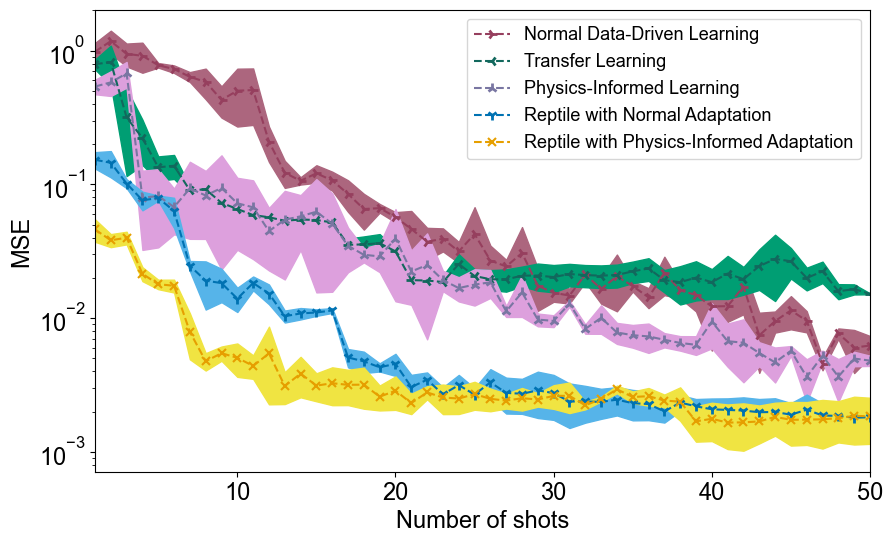

In [94]:
# Testing
test_loss_reference = [0.0099]

size = 50
x = np.arange(1,size+1,1)

plt.figure(figsize=(10,6))
plt.rc('font', size=17)

plt.plot(x, test_loss_normal_pfr_mean[:size], '--', color='#963F5E', marker='4', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Normal Data-Driven Learning')
plt.fill_between(x, test_loss_normal_pfr_mean[:size] - test_loss_normal_pfr_std[:size], test_loss_normal_pfr_mean[:size] + test_loss_normal_pfr_std[:size], edgecolor="#AC667E", facecolor="#AC667E")

plt.plot(x, test_loss_transfer_pfr_mean[:size], '--', color='#12685D', marker='3', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Transfer Learning')
plt.fill_between(x, test_loss_transfer_pfr_mean[:size] - test_loss_transfer_pfr_std[:size], test_loss_transfer_pfr_mean[:size] + test_loss_transfer_pfr_std[:size], edgecolor="#009E73", facecolor="#009E73")

plt.plot(x, test_loss_PI_pfr_mean[:size], '--', color='#7976A2', marker='2', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Physics-Informed Learning')
plt.fill_between(x, test_loss_PI_pfr_mean[:size] - test_loss_PI_pfr_std[:size], test_loss_PI_pfr_mean[:size] + test_loss_PI_pfr_std[:size], edgecolor="plum", facecolor="plum")

plt.plot(x, test_loss_reptile_pfr_mean[:size], '--', color='#0072B2', marker='1', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Reptile with Normal Adaptation')
plt.fill_between(x, test_loss_reptile_pfr_mean[:size] - test_loss_reptile_pfr_std[:size], test_loss_reptile_pfr_mean[:size] + test_loss_reptile_pfr_std[:size], edgecolor="#56B4E9", facecolor="#56B4E9")

plt.plot(x, test_loss_PI_reptile_pfr_mean[:size], '--', color='#E69F00', marker='x', linewidth=1.5, markersize=5.5, markeredgewidth=1.5, label='Reptile with Physics-Informed Adaptation')
plt.fill_between(x, test_loss_PI_reptile_pfr_mean[:size] - test_loss_PI_reptile_pfr_std[:size], test_loss_PI_reptile_pfr_mean[:size] + test_loss_PI_reptile_pfr_std[:size], edgecolor="#F0E442", facecolor="#F0E442")

# plt.plot(x, test_loss_reference*(size), color='#E47159', linewidth=1.5, label='Reference MSE')

plt.legend(fontsize=13)
plt.xlabel("Number of shots")
plt.ylabel("MSE")
plt.margins(x=0)
plt.yscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('pfr_fewshots.pdf')
plt.show()